In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm
import xscale as xsc
import xrft

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.29:43243 Dashboard: http://10.148.1.29:8787/status,Cluster Workers: 6 Cores: 24 Memory: 300.00 GB


_________
# 1. Read dataset
## to compute geostrophic terms


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_us = xr.open_dataset(out_dir_zarr+'U_surface_rechunk.nc')
ds_vs = xr.open_dataset(out_dir_zarr+'V_surface_rechunk.nc')

ds = xr.merge([ds_us,ds_vs,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
    depth    float64 0.5
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) fl

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}})
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center


In [7]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')

## 1.1 rspectra for total uv

In [28]:
chunks={'time': 9415, 'lat': 20, 'lon': 20} # time chunck: (2 months)

u_ij = gridx.interp(ds['U'],'X')   
u_ij = u_ij.chunk(chunks) 

v_ij = gridx.interp(ds['V'],'Y')   
v_ij = v_ij.chunk(chunks) 

uv = u_ij + 1j*v_ij
uv = np.real(uv).rename('uv')    
uv

<xarray.DataArray 'uv' (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(9415, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [30]:
uv_1 = uv.isel(time=slice(1883*0,1883*2))
uv_2 = uv.isel(time=slice(1883*1,1883*3))
uv_3 = uv.isel(time=slice(1883*2,1883*4))
uv_4 = uv.isel(time=slice(1883*3,1883*5))

In [65]:
uv_fft_complex = xrft.dft(uv_1.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/3766*3600
E_uv_mean = E_uv_segments.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_uv_mean = E_uv_mean.assign_coords(freq_cpd=E_uv_mean.freq_time * 86400.) 
E_uv_mean_1 = E_uv_mean
E_uv_mean_1.load()

<xarray.DataArray 'fftn-a20f1504de14ebb66daa7b0789c15156' (freq_time: 3766)>
array([2192.4308  +0.j, 4579.523684+0.j, 6365.234358+0.j, ..., 4793.344591+0.j,
       6365.234358+0.j, 4579.523684+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.006373 0.01275 0.01912 ...
    freq_time_spacing  float64 0.006373
    freq_cpd           (freq_time) float64 0.0 550.6 1.101e+03 1.652e+03 ...

In [37]:
uv_fft_complex = xrft.dft(uv_2.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/3766*3600
E_uv_mean = E_uv_segments.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_uv_mean = E_uv_mean.assign_coords(freq_cpd=E_uv_mean.freq_time * 86400.) 
E_uv_mean_2 = E_uv_mean
E_uv_mean_2.load()

<xarray.DataArray 'fftn-76d098723963839a32701bf4353c3d05' (freq_time: 3766)>
array([2154.734075+0.j, 4702.392281+0.j, 4330.677207+0.j, ..., 4991.165294+0.j,
       4330.677207+0.j, 4702.392281+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.006373 0.01275 0.01912 ...
    freq_time_spacing  float64 0.006373
    freq_cpd           (freq_time) float64 0.0 550.6 1.101e+03 1.652e+03 ...

In [38]:
uv_fft_complex = xrft.dft(uv_3.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/3766*3600
E_uv_mean = E_uv_segments.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_uv_mean = E_uv_mean.assign_coords(freq_cpd=E_uv_mean.freq_time * 86400.) 
E_uv_mean_3 = E_uv_mean
E_uv_mean_3.load()

<xarray.DataArray 'fftn-7371f383ae2ee9d95cd23b84159c71b4' (freq_time: 3766)>
array([ 5947.777205+0.j, 13881.173099+0.j,  8710.718913+0.j, ...,
        9110.433056+0.j,  8710.718913+0.j, 13881.173099+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.006373 0.01275 0.01912 ...
    freq_time_spacing  float64 0.006373
    freq_cpd           (freq_time) float64 0.0 550.6 1.101e+03 1.652e+03 ...

In [39]:
uv_fft_complex = xrft.dft(uv_4.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/3766*3600
E_uv_mean = E_uv_segments.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_uv_mean = E_uv_mean.assign_coords(freq_cpd=E_uv_mean.freq_time * 86400.) 
E_uv_mean_4 = E_uv_mean
E_uv_mean_4.load()

<xarray.DataArray 'fftn-c0d917a3db88080aae60f1198aa18381' (freq_time: 3766)>
array([ 5853.812975+0.j, 16272.7163  +0.j, 12470.763197+0.j, ...,
        7774.454041+0.j, 12470.763197+0.j, 16272.7163  +0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.006373 0.01275 0.01912 ...
    freq_time_spacing  float64 0.006373
    freq_cpd           (freq_time) float64 0.0 550.6 1.101e+03 1.652e+03 ...

# Figure together

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


Text(0.5,1,'')

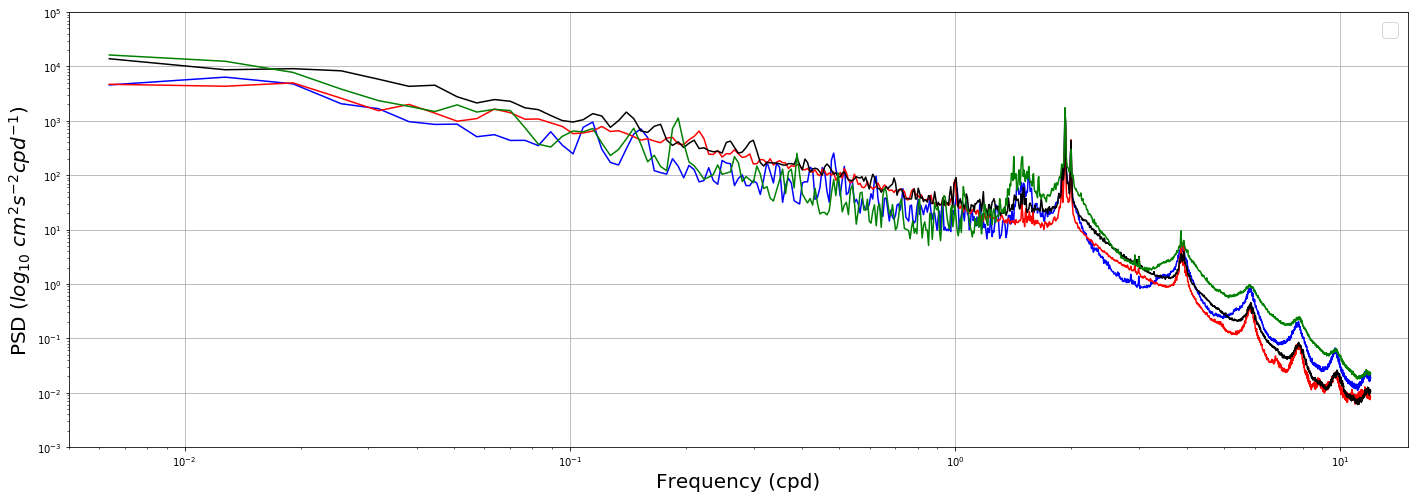

In [69]:
fig, ax = plt.subplots(figsize=(24,8))


# total uv
E_uv_mean_1.where(E_uv_mean_1.freq_time>0).plot(ax=ax,color='blue')
E_uv_mean_2.where(E_uv_mean_2.freq_time>0).plot(ax=ax,color='red')
E_uv_mean_3.where(E_uv_mean_3.freq_time>0).plot(ax=ax,color='black')
E_uv_mean_4.where(E_uv_mean_4.freq_time>0).plot(ax=ax,color='green')

ax.set_xscale('log'); 
ax.set_yscale('log')

ax.set_ylim([10e-4,10e4])
ax.set_xlim([5*10e-4,1.5*10e0])


#ax.set_ylim([-2.,5.])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
#ax.set_yticks([-2.,-1.,0.,1.,2.,3.,4.,5.])

ax.legend(prop={'size': 20}); ax.grid()
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=20)
ax.set_xlabel('Frequency (cpd)',fontsize=20)
ax.set_title('',fontsize=24)

# 3. 2D spectrum

In [74]:
uhat1 = xrft.power_spectrum(gridx.interp(ds['U'].isel(depth=1),'X').chunk({'lat':201,'lon':177,'time':1883}),dim=['lon','time'], detrend='constant', window=True, chunks_to_segments=True).compute()
vhat1 = xrft.power_spectrum(gridx.interp(ds['V'].isel(depth=1),'Y').chunk({'lat':201,'lon':177,'time':1883}),dim=['lon','time'], detrend='constant', window=True, chunks_to_segments=True).compute()

In [78]:
uhat1_mean = uhat1.mean(dim=['time_segment','lon_segment'])

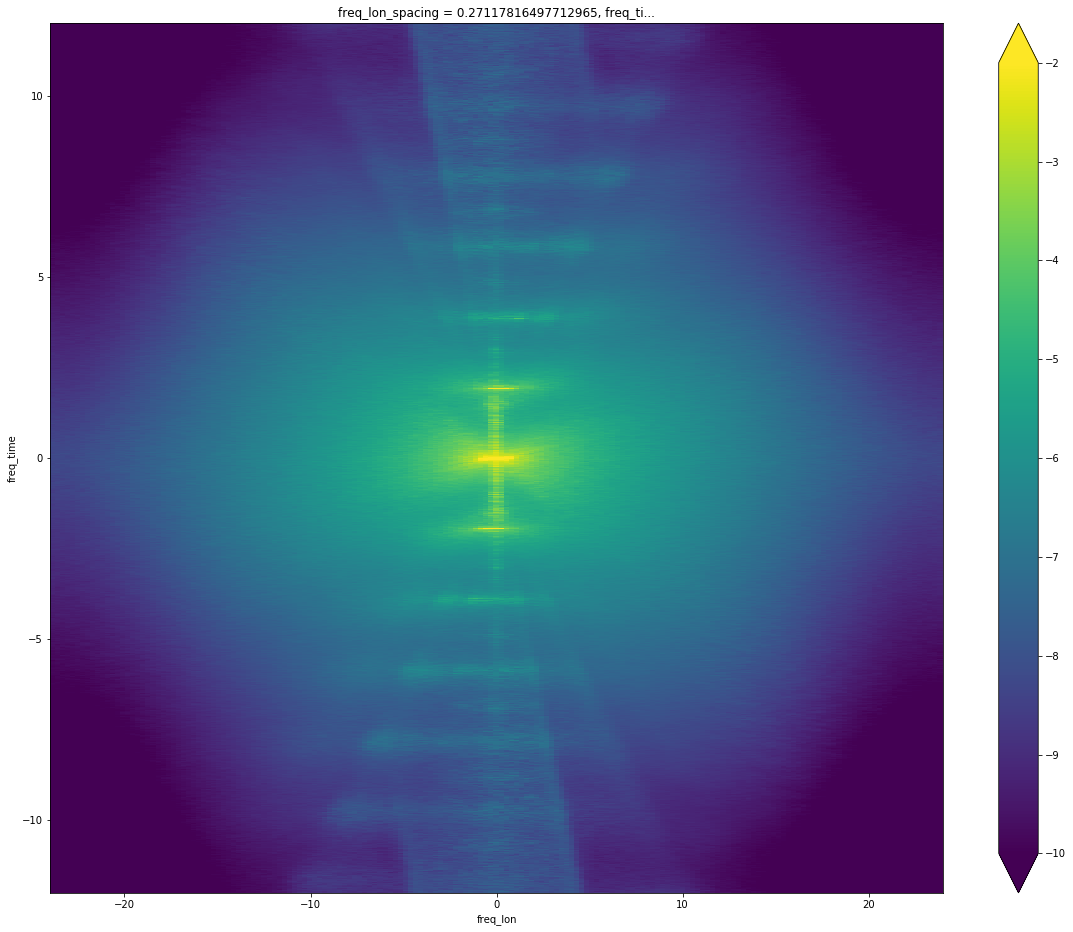

In [49]:
fig = plt.figure(figsize=(20,16))
np.log10(uhat2.mean(dim='lat') + vhat2.mean(dim='lat')).plot(vmin= -10, vmax = -2)

In [43]:
KE = np.real(KE).rename('KE')
KE = KE.to_dataset()
KE

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
Data variables:
    KE       (time, lat, lon) float32 0.024190357 0.024316886 0.025969876 ...

In [44]:
#E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
KE = KE.assign_coords(lat=1500 * np.arange(201)) 
KE

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) int64 0 1500 3000 4500 6000 7500 9000 10500 12000 13500 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
Data variables:
    KE       (time, lat, lon) float32 0.024190357 0.024316886 0.025969876 ...

In [51]:
ke1 = xrft.power_spectrum(KE.KE.chunk({'lat':201,'lon':177,'time':1883}),dim=['lat','time'], detrend='constant', window=True, chunks_to_segments=True).compute()
#ke2 = xrft.power_spectrum(KE.chunk({'lat':201,'lon':177,'time':1883}),dim=['lat','time'], detrend='constant', window=True, chunks_to_segments=True).compute()

In [54]:
ke1_mean = ke1.mean(dim=['time_segment','lat_segment','lon'])
ke1_mean

<xarray.DataArray 'rechunk-merge-b11405aa1c0855c2dbb03ce652e5bdfa' (freq_time: 1883, freq_lat: 201)>
array([[2.521162e-09, 2.670305e-09, 2.583267e-09, ..., 2.391079e-09,
        2.506181e-09, 2.402979e-09],
       [2.480490e-09, 2.837080e-09, 2.910871e-09, ..., 2.629832e-09,
        2.847268e-09, 2.417079e-09],
       [2.401424e-09, 2.526081e-09, 2.617300e-09, ..., 2.565860e-09,
        2.635142e-09, 2.281783e-09],
       ...,
       [2.281783e-09, 2.635142e-09, 2.565860e-09, ..., 2.617300e-09,
        2.526081e-09, 2.401424e-09],
       [2.417079e-09, 2.847268e-09, 2.629832e-09, ..., 2.910871e-09,
        2.837080e-09, 2.480490e-09],
       [2.402979e-09, 2.506181e-09, 2.391079e-09, ..., 2.583267e-09,
        2.670305e-09, 2.521162e-09]])
Coordinates:
  * freq_time          (freq_time) float64 -11.99 -11.98 -11.97 -11.96 ...
  * freq_lat           (freq_lat) float64 -0.0003317 -0.0003284 -0.000325 ...
    freq_lat_spacing   float64 3.317e-06
    freq_time_spacing  float64 0.01275

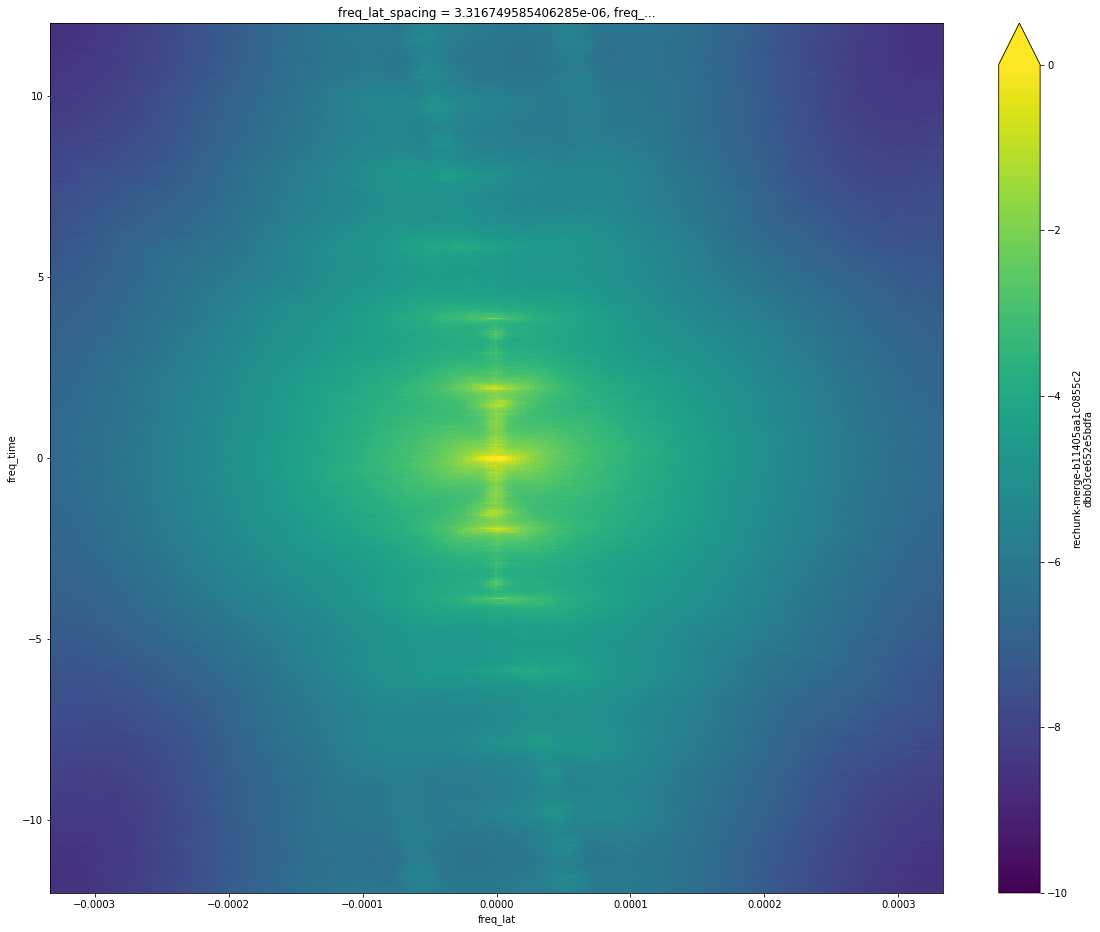

In [57]:
fig = plt.figure(figsize=(20,16))
np.log10(ke1_mean).plot(vmin= -10, vmax = 0)

In [71]:
cluster.scheduler.close()

<Future finished result=None>